## Yahoo Finance experimentation

In [1]:
import yfinance as yf
import os
import time
import requests
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from typing import Dict, List, Any, Optional
from bs4 import BeautifulSoup
import feedparser
import json

from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Get stock information for Apple (AAPL)
ticker = "AAPL"
stock = yf.Ticker(ticker)


info = stock.info
print(f"Company: {info.get('longName', 'N/A')}")
print(f"Sector: {info.get('sector', 'N/A')}")
print(f"Current Price: ${info.get('currentPrice', 'N/A')}")
print(f"Market Cap: ${info.get('marketCap', 'N/A'):,}")

# Get historical data for the last 30 days
hist_data = stock.history(period="1mo")
print(f"\nLatest closing price: ${hist_data.iloc[-1]['Close']:.2f}")
print(f"30-day high: ${hist_data['High'].max():.2f}")
print(f"30-day low: ${hist_data['Low'].min():.2f}")

Company: Apple Inc.
Sector: Technology
Current Price: $253.31
Market Cap: $3,774,437,392,384

Latest closing price: $253.31
30-day high: $257.60
30-day low: $225.95


Data with Moving Average and Daily Returns:
                                Close  20_Day_MA  Daily_Return
Date                                                          
2025-03-31 00:00:00-04:00  221.587616        NaN           NaN
2025-04-01 00:00:00-04:00  222.645020        NaN      0.477194
2025-04-02 00:00:00-04:00  223.343307        NaN      0.313633
2025-04-03 00:00:00-04:00  202.693863        NaN     -9.245607
2025-04-04 00:00:00-04:00  187.920029        NaN     -7.288743


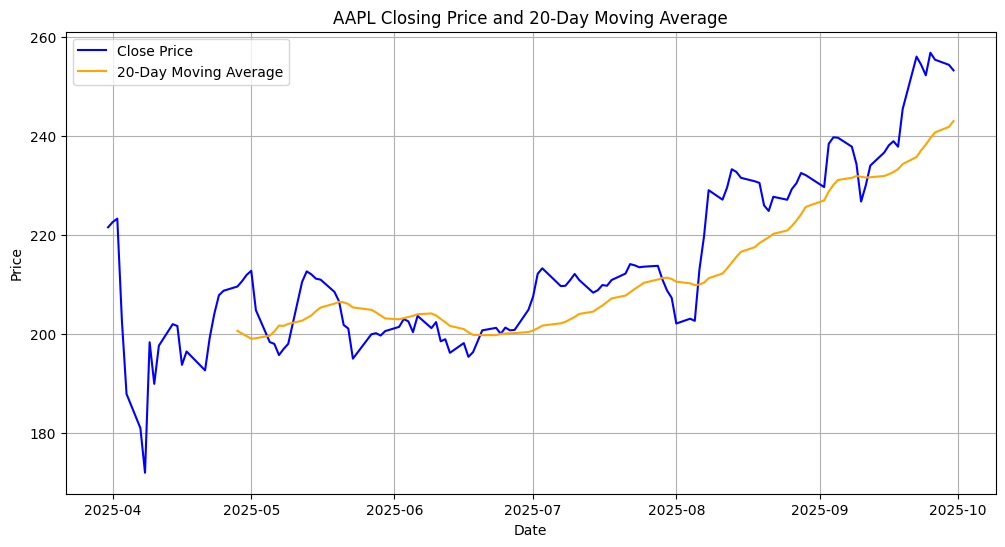

In [3]:
# plot info
symbol = 'AAPL'

stock = yf.Ticker(symbol)
info = stock.info
data = stock.history(period="6mo")

data['20_Day_MA'] = data['Close'].rolling(window=20).mean()

data['Daily_Return'] = data['Close'].pct_change() * 100

print("Data with Moving Average and Daily Returns:")
print(data[['Close', '20_Day_MA', 'Daily_Return']].head())

plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['20_Day_MA'], label='20-Day Moving Average', color='orange')
plt.title(f'{symbol} Closing Price and 20-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Get Complete Stock data 

Reference: https://www.geeksforgeeks.org/python/getting-stock-symbols-with-yfinance-in-python/


In [4]:
from src.aggregator import FinancialAggregator, NewsAggregator

In [5]:

tsla = FinancialAggregator().execute("TSLA", "1y")
pprint(tsla)

{'52_week_high': 488.54,
 '52_week_low': 212.11,
 'avg_volume_30d': 87781344.23333333,
 'beta': 2.065,
 'company_summary': 'Tesla, Inc. designs, develops, manufactures, leases, and '
                    'sells electric vehicles, and energy generation and '
                    'storage systems in the United States, China, and '
                    'internationally. The company operates in two segments, '
                    'Automotive; and Energy Generation and Storage. The '
                    'Automotive segment offers electric vehicles, as well as '
                    'sells automotive regulatory credits; and non-warranty '
                    'after-sales vehicle, used vehicles, body shop and parts, '
                    'supercharging, retail merchandise, and vehicle insurance '
                    'services. Thi',
 'current_price': 443.625,
 'dividend_yield': None,
 'historical_data': [{'Close': 329.30999755859375,
                      'Dividends': 0.0,
                      '

## Collect Information from News Sources

In [6]:
msft = NewsAggregator().execute("MSFT", 10)

# Print information
for news in msft:
    pprint(news)

{'link': 'https://finance.yahoo.com/m/0f8ebd41-11b1-3d90-922f-7191ec41cd21/coreweave-stock-jumps-on.html?.tsrc=rss',
 'published': 'Tue, 30 Sep 2025 18:19:05 +0000',
 'source': 'Yahoo Finance',
 'summary': 'CoreWeave stock jumped amid an expanded artificial intelligence '
            'cloud computing agreement with Meta Platforms.',
 'title': 'CoreWeave Stock Jumps On Expanded Meta Cloud Computing Agreement'}
{'link': 'https://finance.yahoo.com/news/bofa-maintains-cautious-stance-marvell-180449317.html?.tsrc=rss',
 'published': 'Tue, 30 Sep 2025 18:04:49 +0000',
 'source': 'Yahoo Finance',
 'summary': 'Marvell Technology Inc. (NASDAQ:MRVL) takes the second place in '
            'our list of worst-performing data center stocks in 2025, with a '
            'nearly 25% YTD decline. The overall consensus of analysts remains '
            'largely positive, but some analysts still hold a cautious stance. '
            'On September 25, Bank of America Securities’ Vivek Arya '
            